# Neural Collaborative Filtering
1. [논문](https://arxiv.org/pdf/1708.05031.pdf)
2. Keras로 작성된 [저자 코드](https://github.com/hexiangnan/neural_collaborative_filtering)
3. 논문은 0과 1로 user-item interaction으로 matrix을 나타내고 학습했으나, 이번 실습에서는 rating을 직접 예측하고, loss를 구해보는 것을 진행한다.

## Configuration

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import math
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Load Dataset
- KMRD 데이터셋 활용
- google colab의 경우 data path 다시 확인하기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = '/content/drive/MyDrive/data/kmrd/kmr_dataset/datafile/kmrd-small'

In [5]:
def read_data(data_path):
  df = pd.read_csv(os.path.join(data_path,'rates.csv'))
  train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)
  return train_df, val_df

In [6]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [8]:
# 학습할 영화 데이터 분석
train_df, val_df = read_data(data_path)

In [9]:
print(train_df.shape)
print(train_df.head())

(112568, 4)
         user  movie  rate        time
137023  48423  10764    10  1212241560
92868   17307  10170    10  1122185220
94390   18180  10048    10  1573403460
22289    1498  10001     9  1432684500
80155   12541  10022    10  1370458140


In [10]:
val_df.shape

(28142, 4)

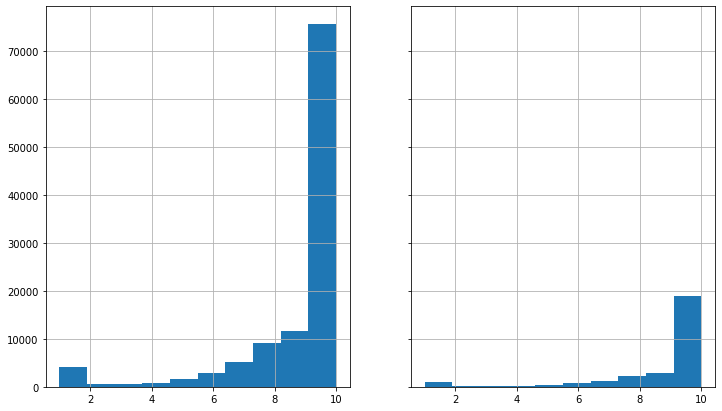

In [11]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12,7))
ax = ax.ravel()

train_df['rate'].hist(ax=ax[0])
val_df['rate'].hist(ax=ax[1])

In [12]:
train_df['rate'].describe()

count    112568.000000
mean          8.948369
std           2.114602
min           1.000000
25%           9.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rate, dtype: float64

## movie dataframe 불러오기

In [13]:
# Load all related dataframe
movies_df = pd.read_csv(os.path.join(data_path, 'movies.txt'), sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')

castings_df = pd.read_csv(os.path.join(data_path, 'castings.csv'), encoding='utf-8')
countries_df = pd.read_csv(os.path.join(data_path, 'countries.csv'), encoding='utf-8')
genres_df = pd.read_csv(os.path.join(data_path, 'genres.csv'), encoding='utf-8')

# Get genre information
genres = [(list(set(x['movie'].values))[0], '/'.join(x['genre'].values)) for index, x in genres_df.groupby('movie')]
combined_genres_df = pd.DataFrame(data=genres, columns=['movie', 'genres'])
combined_genres_df = combined_genres_df.set_index('movie')

# Get castings information
castings = [(list(set(x['movie'].values))[0], x['people'].values) for index, x in castings_df.groupby('movie')]
combined_castings_df = pd.DataFrame(data=castings, columns=['movie','people'])
combined_castings_df = combined_castings_df.set_index('movie')

# Get countries for movie information
countries = [(list(set(x['movie'].values))[0], ','.join(x['country'].values)) for index, x in countries_df.groupby('movie')]
combined_countries_df = pd.DataFrame(data=countries, columns=['movie', 'country'])
combined_countries_df = combined_countries_df.set_index('movie')

movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)

In [14]:
movies_df.head()

,title,title_eng,year,grade,genres,people,country
movie,,,,,,,
10001,시네마 천국,"Cinema Paradiso , 1988",2013.0,전체 관람가,드라마/멜로/로맨스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","이탈리아,프랑스"
10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 8637, 5104, 9986, 7470, 9987]",미국
10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 5104, 391, 5106, 5105, 5107,...",미국
10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부/SF/판타지/코미디,"[1076, 4603, 1031, 5104, 10001, 5984, 10002, 1...",미국
10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1997.0,PG,판타지/모험/SF/액션,"[1007, 535, 215, 1236, 35]",미국


- 논문:  user latent vector + item latent vector
- 새롭게 생각할 수 있는 방법: user latent vector + item latent vector + etc vector (예시) meta information 

In [15]:
# 영화 데이터의 메타 정보 확인
movieName_dict = movies_df.to_dict()['title']
genres_dict = movies_df.to_dict()['genres']

In [16]:
movies_df['genres']

movie
10001       드라마/멜로/로맨스
10002           SF/코미디
10003           SF/코미디
10004    서부/SF/판타지/코미디
10005     판타지/모험/SF/액션
             ...      
10995              스릴러
10996              코미디
10997               공포
10998    드라마/액션/모험/스릴러
10999        SF/드라마/공포
Name: genres, Length: 999, dtype: object